In [1]:
import pandas as pd
file_path = 'train.csv'

# Loading the data into a pandas DataFrame
try:
    df = pd.read_csv(file_path)

    # Display the first few rows of the DataFrame to understand its structure
    df_head = df.head()
except Exception as e:
    df_head = str(e)

df_head

,date,temperature,light,airHumidity,humidity
0,2023-07-10 00:00:00,24.558222,0.0,72.278208,86.485813
1,2023-07-10 00:01:00,24.849800,0.0,72.191887,85.327090
2,2023-07-10 00:02:00,24.788302,0.0,70.960825,85.372835
3,2023-07-10 00:03:00,24.979886,0.0,71.424718,85.828448
4,2023-07-10 00:04:00,24.462985,0.0,71.010175,86.997323


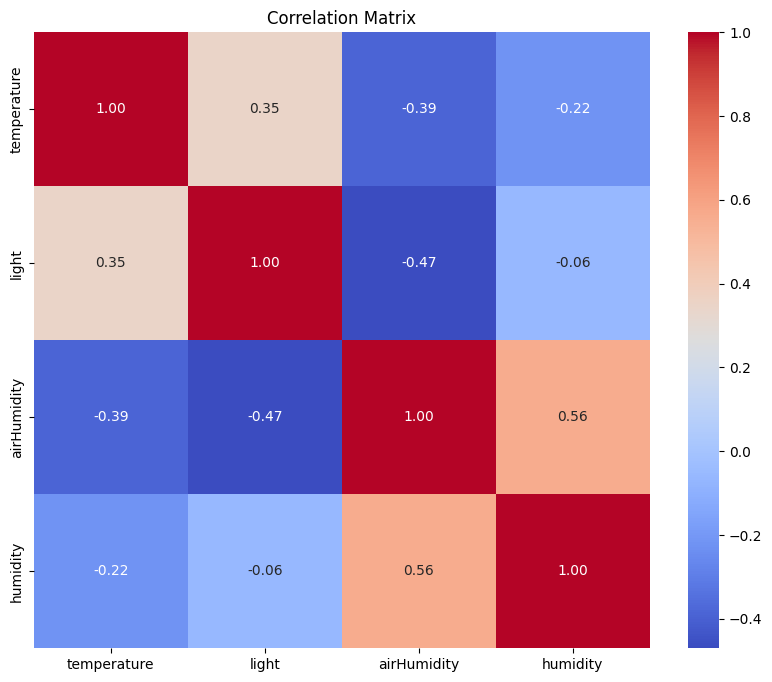

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.drop(columns=['date']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

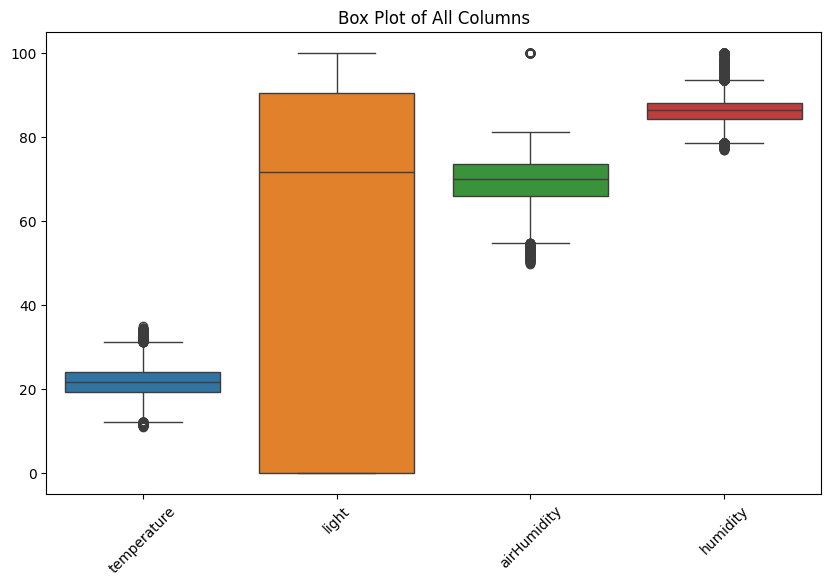

In [3]:


def plot_boxplots(dataframe):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dataframe.drop(columns=["date"]))  # Dropping the 'date' column for the box plot
    plt.title("Box Plot of All Columns")
    plt.xticks(rotation=45)
    plt.show()

plot_boxplots(df)

In [4]:
# Calculate the first and third quartiles (Q1 and Q3)
Q1 = df['airHumidity'].quantile(0.25)
Q3 = df['airHumidity'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the outlier threshold as 1.5 times IQR above Q3
outlier_threshold = Q3 + 1.5 * IQR

# Count the number of values in 'airHumidity' that are above this threshold
outliers_count = df[df['airHumidity'] > outlier_threshold].shape[0]

print("Number of outliers in 'airHumidity':", outliers_count)
print("Outlier Threshold for 'airHumidity':", outlier_threshold)

Number of outliers in 'airHumidity': 56
Outlier Threshold for 'airHumidity': 84.92385103574827


In [5]:
# Checking for potential errors in the 'date' column

# Convert 'date' to datetime if not already done
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 1. Check for Non-sequential or Irregular Time Intervals
# This assumes the data should be in regular intervals (e.g., every minute)
date_diff = df['date'].diff().unique()

# 2. Check for Duplicate Dates/Times
duplicate_dates = df['date'].duplicated().sum()

# 3. Check for Out-of-Range Dates
# This would be more meaningful if we know the expected date range
min_date = df['date'].min()
max_date = df['date'].max()

# 4. Check for any NaT values which indicate incorrect formats or conversion issues
nat_counts = df['date'].isna().sum()

date_diff, duplicate_dates, min_date, max_date, nat_counts


(<TimedeltaArray>
 [NaT, '0 days 00:01:00']
 Length: 2, dtype: timedelta64[ns],
 0,
 Timestamp('2023-07-10 00:00:00'),
 Timestamp('2023-11-08 01:59:00'),
 0)

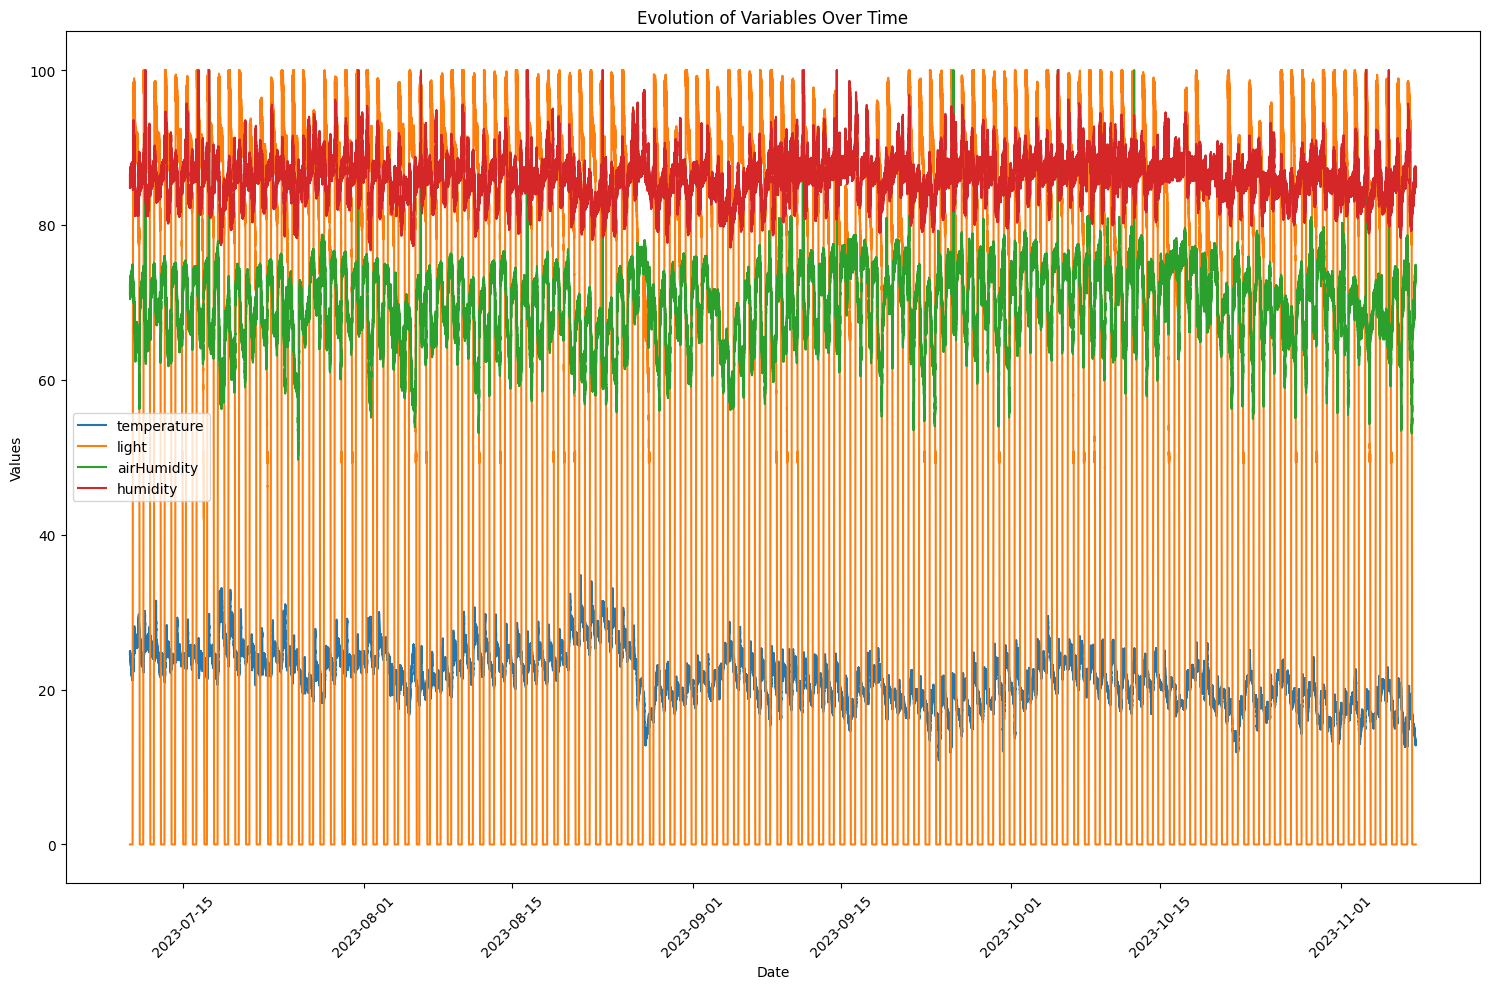

In [6]:
import matplotlib.pyplot as plt

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(15, 10))

# Plotting each variable
for column in ['temperature', 'light', 'airHumidity', 'humidity']:
    plt.plot(df['date'], df[column], label=column)

plt.title('Evolution of Variables Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Dataset Analysis Conclusion

1. **Light Sensor Variability:** The light sensor exhibits fluctuations, going up and down every day. However, it not really that well calibrated, since it reports 100% pretty much every day.

2. **Sensor Noise:** All of the sensors in the dataset demonstrate a degree of variability per day, with varying levels of fluctuation and inconsistency in the readings.

3. **Air Humidity Peaks:** The air humidity sensor occasionally shows sharp increases in its readings, shooting up from values around 84.6 to as high as 100. These spikes suggest sporadic, significant changes in air humidity.


In [7]:
# Convert 'date' to datetime if not already done
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index of the DataFrame for rolling operation
df.set_index('date', inplace=True)

# Apply a rolling mean with a window of 2880 minutes (2 days)
df_rolling_mean = df.rolling(window='2880T').mean()

# Reset the index if needed
df_rolling_mean = df_rolling_mean.reset_index()

# Displaying the first few rows of the modified DataFrame
print(df_rolling_mean.head())


                 date  temperature  light  airHumidity   humidity
0 2023-07-10 00:00:00    24.558222    0.0    72.278208  86.485813
1 2023-07-10 00:01:00    24.704011    0.0    72.235047  85.906451
2 2023-07-10 00:02:00    24.732108    0.0    71.810306  85.728579
3 2023-07-10 00:03:00    24.794053    0.0    71.713909  85.753546
4 2023-07-10 00:04:00    24.727839    0.0    71.573163  86.002302


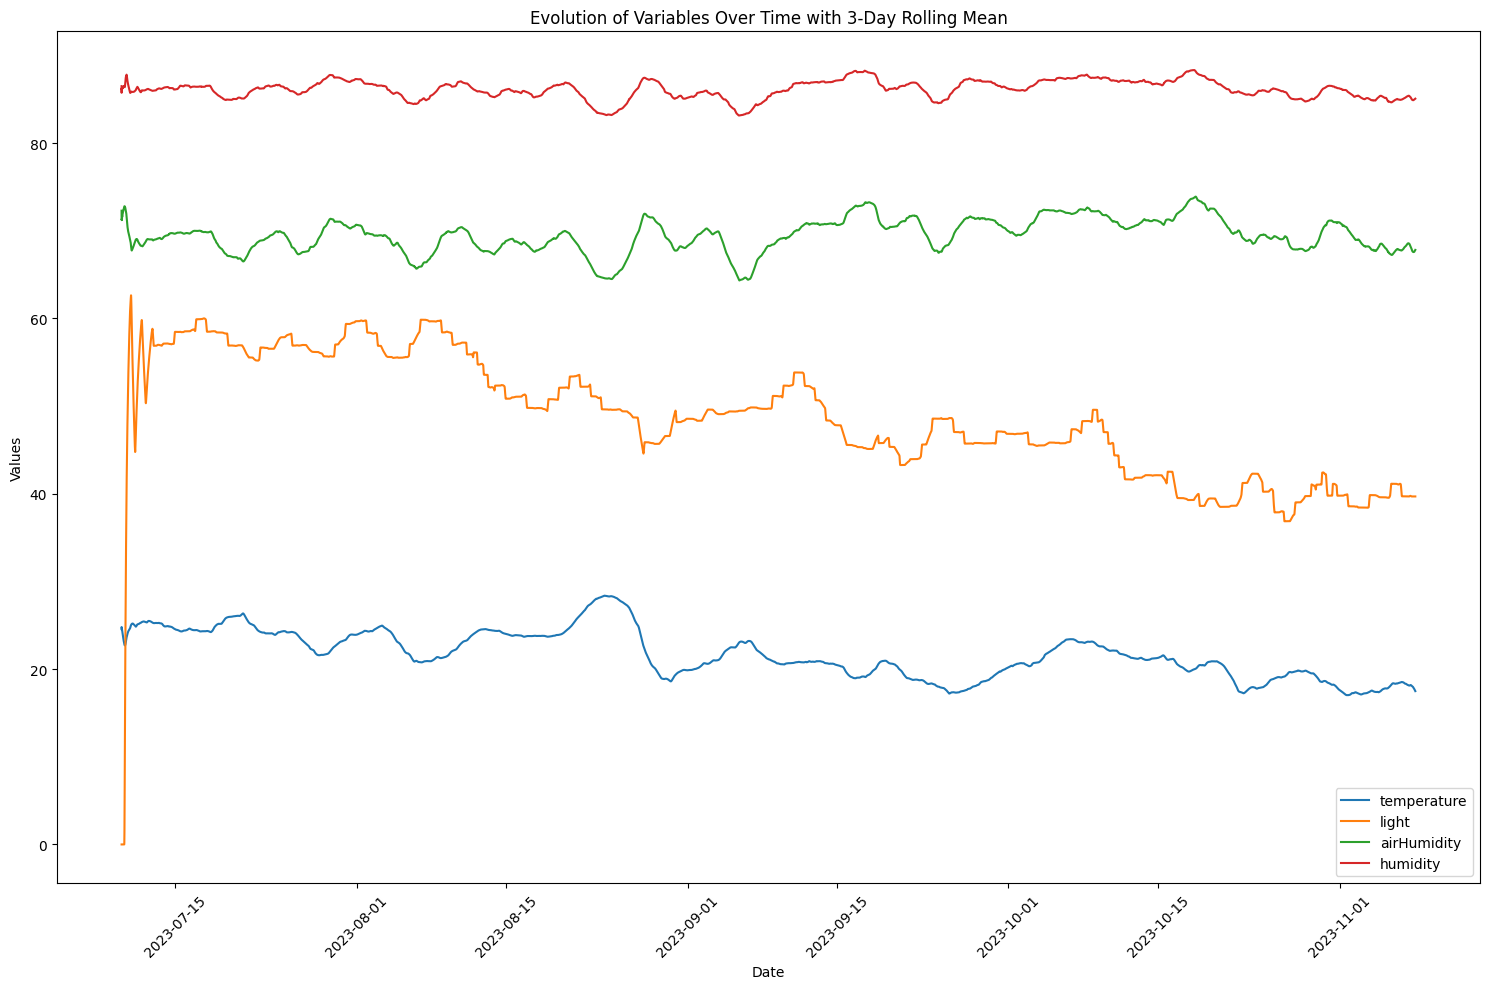

In [8]:
# Check if 'date' is already the index
if not df.index.name == 'date':
    df.set_index('date', inplace=True)

# Apply a rolling mean with a window of 4320 minutes (3 days)
df_rolling_mean = df.rolling(window='4320T').mean()  # 'T' stands for minutes

# Plotting the evolution of all four variables with the rolling mean applied
plt.figure(figsize=(15, 10))

# Plotting each variable with the rolling mean
for column in ['temperature', 'light', 'airHumidity', 'humidity']:
    plt.plot(df_rolling_mean.index, df_rolling_mean[column], label=column)

plt.title('Evolution of Variables Over Time with 3-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


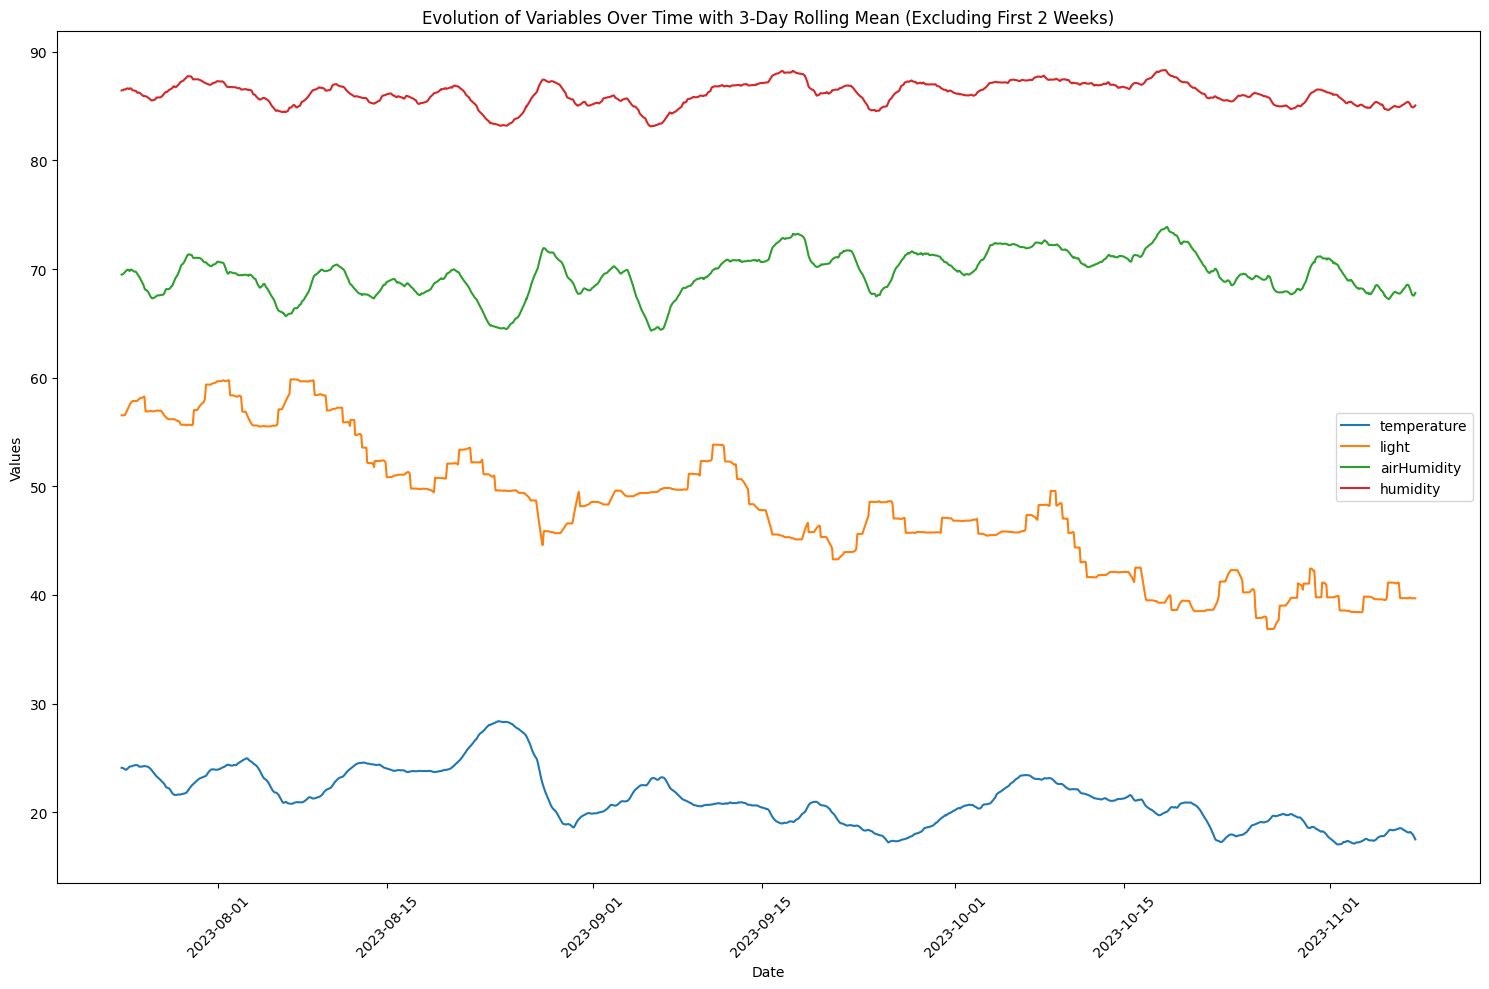

In [9]:
# Dropping the first couple of weeks from the DataFrame with the rolling mean
start_date_to_keep = df_rolling_mean.index.min() + pd.Timedelta(weeks=2)
df_filtered = df_rolling_mean[df_rolling_mean.index >= start_date_to_keep]

# Replotting the evolution of all four variables with the rolling mean applied, excluding the first two weeks
plt.figure(figsize=(15, 10))

# Plotting each variable with the rolling mean after filtering
for column in ['temperature', 'light', 'airHumidity', 'humidity']:
    plt.plot(df_filtered.index, df_filtered[column], label=column)

plt.title('Evolution of Variables Over Time with 3-Day Rolling Mean (Excluding First 2 Weeks)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Saving the filtered data to 'data/vibrani-anomaly.csv'
save_path = 'vibrani-anomaly.csv'
df_filtered.to_csv(save_path)

In [11]:
!pip install statsmodels


/home/josalhor/Desktop/hack-eps-2023-eurecat/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/josalhor/Desktop/hack-eps-2023-eurecat/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/josalhor/Desktop/hack-eps-2023-eurecat/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/josalhor/Desktop/hack-eps-2023-eurecat/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters

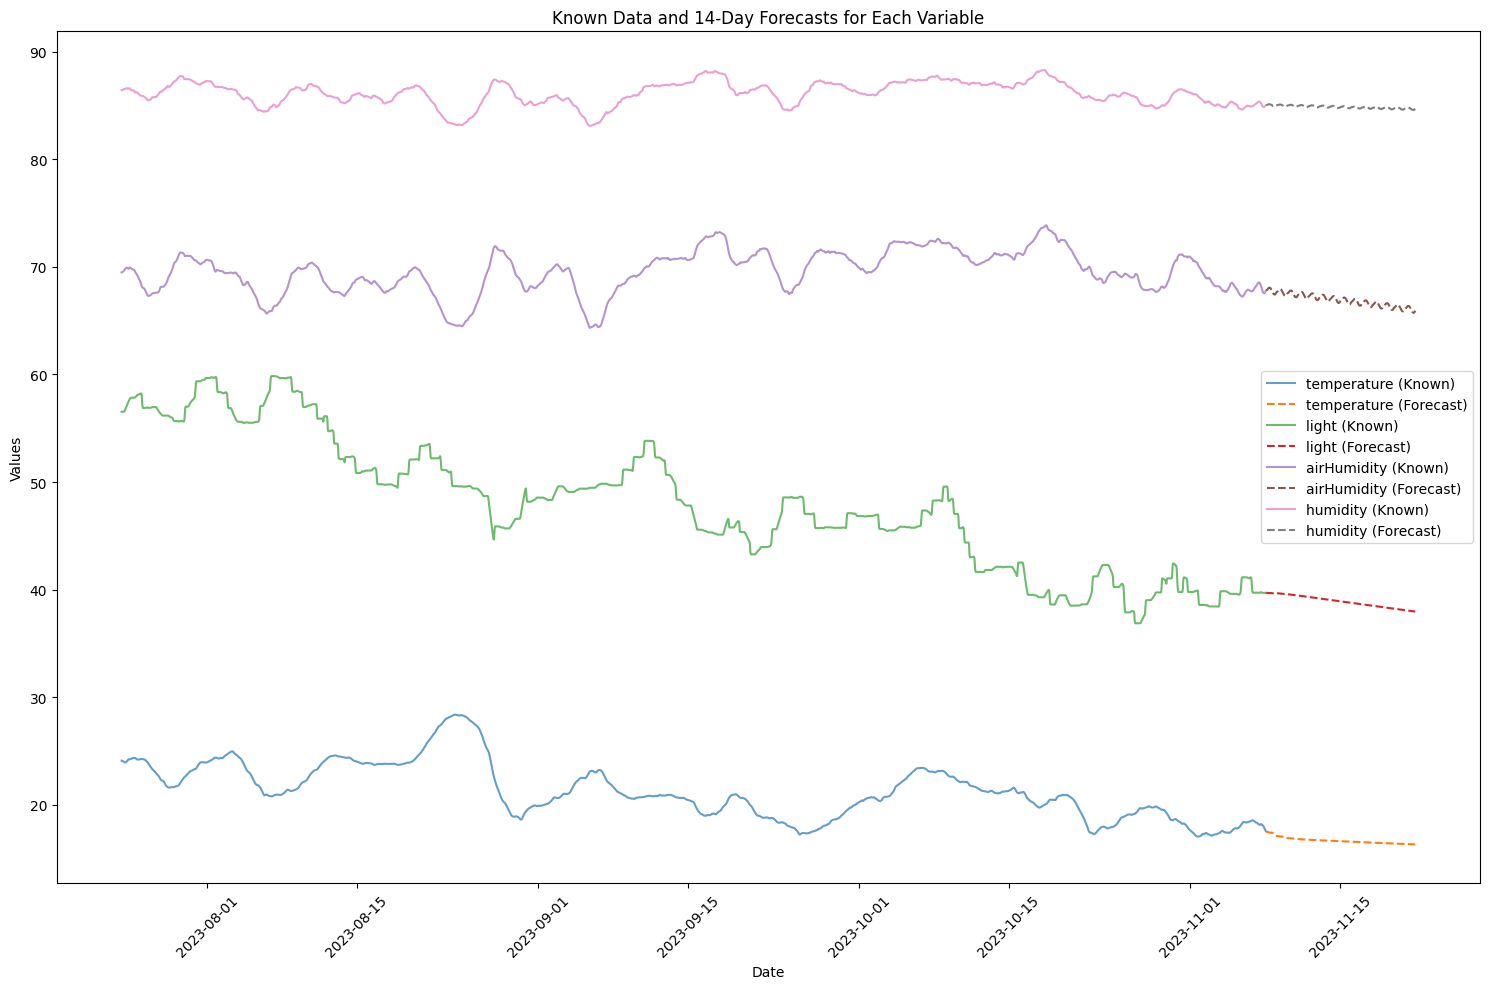

'vibrarni-forecast.csv'

In [14]:
import numpy as np
import statsmodels.api as sm

# Resampling data to hourly for faster processing
hourly_data = df_filtered.resample('H').mean()

# We will store the forecasts for each column in this dictionary
forecasts = {}

# Predicting for each column and storing the results
for column in hourly_data.columns:
    # Fit a SARIMAX model (simple model for demonstration)
    model = sm.tsa.statespace.SARIMAX(hourly_data[column], 
                                      order=(1, 0, 1), 
                                      seasonal_order=(1, 0, 1, 24))  # assuming daily seasonality
    results = model.fit(disp=False)

    # Forecasting the next 14 days
    forecasts[column] = results.forecast(steps=14*24)  # 14 days, hourly data

# Combining the forecast data into a DataFrame
forecast_df = pd.DataFrame(forecasts, index=pd.date_range(start=hourly_data.index[-1], periods=14*24+1, freq='H')[1:])

# Save the forecast results
forecast_save_path = 'vibrarni-forecast.csv'
forecast_df.to_csv(forecast_save_path)

# Plotting the known data and forecasts
plt.figure(figsize=(15, 10))

for column in hourly_data.columns:
    # Plot known data
    plt.plot(hourly_data[column], label=f"{column} (Known)", alpha=0.7)
    
    # Plot forecasted data
    plt.plot(forecast_df[column], label=f"{column} (Forecast)", linestyle='--')

plt.title('Known Data and 14-Day Forecasts for Each Variable')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

forecast_save_path



# Limitations of Current Prediction Model

The current forecasting model, based on a simplified SARIMAX approach, utilizes weekly and monthly data to predict future values. However, this approach has several limitations, especially concerning its ability to accurately predict long-term trends and seasonal shifts:

1. **Lack of Yearly Cycle Data:** The model has been trained on a dataset that does not encompass a full yearly cycle. As a result, it lacks exposure to the complete range of seasonal variations, particularly those that occur annually. For instance, as we transition from winter to spring, temperatures will rise. However, since the model hasn't been trained on data from different seasons throughout a year, it might fail to anticipate and accurately predict these natural seasonal changes.

2. **Short-Term Seasonality Focus:** The emphasis on weekly and monthly seasonality means the model is more attuned to short-term fluctuations rather than long-term trends. This short-term focus can lead to inaccuracies in predictions over extended periods, especially when significant seasonal transitions occur.

3. **Future Predictive Limitations:** As the model has not been exposed to a complete set of seasonal data (such as a full year), its predictive power is limited when facing new or unseen seasonal patterns. This limitation becomes particularly evident in scenarios where the data's characteristics change markedly over different times of the year, such as a shift from winter to summer conditions.

In summary, while the model may provide reasonable short-term forecasts, its effectiveness diminishes for longer-term predictions, especially in the face of significant seasonal changes not represented in the training dataset.
